In [2]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from reco.matching import get_highest_energy_fraction_simtracksters


# file_name = "~/Data/pions/new_ntuples_14955802_7.root"
file_name = "~/data/multi/new_ntuples_14992862_991.root"

tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

In [3]:
cx = tracksters["vertices_x"].array()
cy = tracksters["vertices_y"].array()
cz = tracksters["vertices_z"].array()
ce = tracksters["vertices_energy"].array()

sx = simtracksters["stsSC_vertices_x"].array()
sy = simtracksters["stsSC_vertices_y"].array()
sz = simtracksters["stsSC_vertices_z"].array()
se = simtracksters["stsSC_vertices_energy"].array()

## Number of vertices and total energy

In [4]:
nvertices = []
tenergy = []
fracs = []
t_frac = []

for e in range(len(cx)):
    te = ce[e]  # get event
    reco_fr, reco_st = get_highest_energy_fraction_simtracksters(tracksters, simtracksters, associations, e)

    for tx in range(len(te)):   
        ve = te[tx]         # get trackster
        fr = reco_fr[tx]
        nvertices.append(len(ve))
        tenergy.append(sum(ve))
        fracs.append(fr)

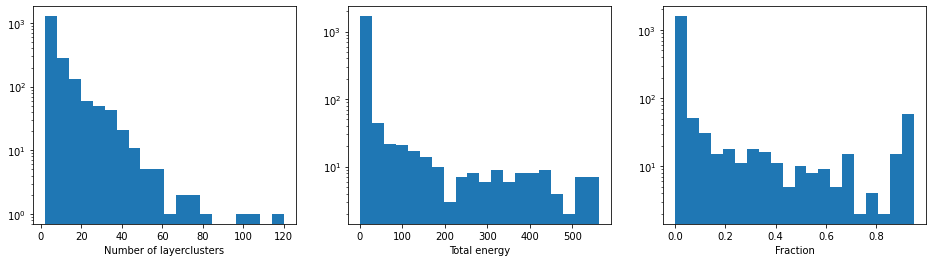

In [5]:
fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(131)
ax.hist(nvertices, bins=20)
ax.set_yscale("log")
ax.set_xlabel("Number of layerclusters")

ax = fig.add_subplot(132)
ax.set_xlabel("Total energy")
ax.hist(tenergy, bins=20)
ax.set_yscale("log")

ax = fig.add_subplot(133)
ax.set_xlabel("Fraction")
ax.set_yscale("log")
ax.hist(fracs, bins=20)

plt.show()

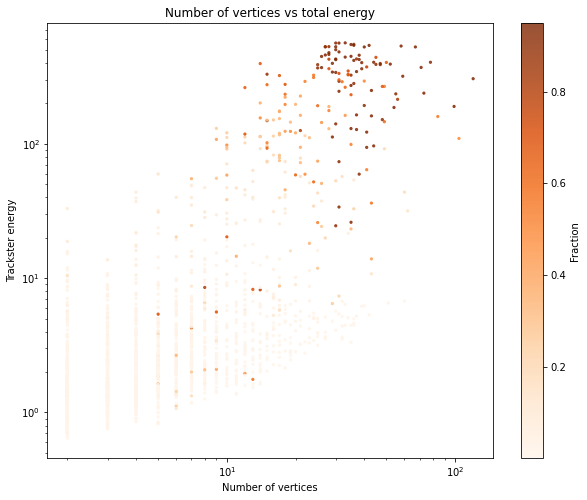

In [6]:
plt.figure(figsize=(10, 8))
plt.title("Number of vertices vs total energy")
plt.xlabel("Number of vertices")
plt.ylabel("Trackster energy")
plt.xscale("log")
plt.yscale("log")

plt.scatter(nvertices, tenergy, c=fracs, s=5, cmap="Oranges", alpha=0.8)
cbar = plt.colorbar()
cbar.set_label("Fraction")
plt.show()
# we can use the fraction as a "completeness" score

## Graph based features

In [7]:
import networkx as nx
from itertools import islice
from reco.graph_utils import create_graph
from reco.plotting import plot_graph_3D

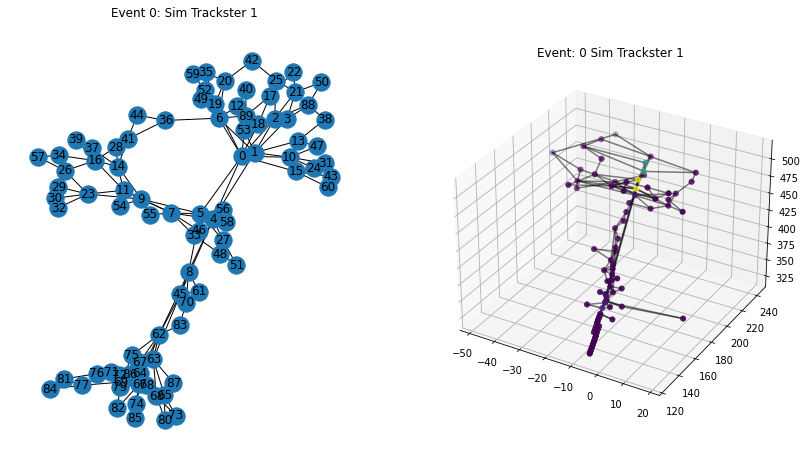

In [8]:
eid = 0
ntx = 1

simgraphs = [(create_graph(x, y, z, e, N=2), e) for x, y, z, e in zip(sx[eid], sy[eid], sz[eid], se[eid])]
G, e = simgraphs[ntx]

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')
ax1.set_title(f"Event {eid}: Sim Trackster {ntx}")
ax2.set_title(f"Event: {eid} Sim Trackster {ntx}")

nx.draw(G, with_labels=True, ax=ax1)
plot_graph_3D(G, e, ax=ax2)

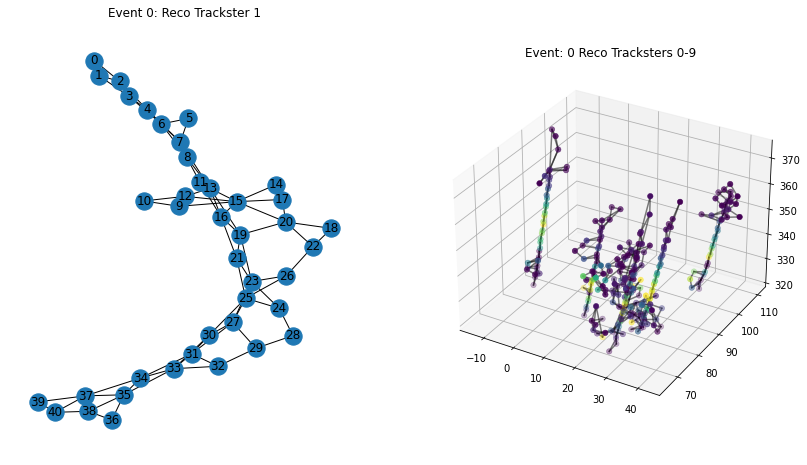

In [9]:
num_graphs = 10

graphs = [(create_graph(x, y, z, e, N=2), e) for x, y, z, e in zip(cx[eid], cy[eid], cz[eid], ce[eid])]

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')
ax1.set_title(f"Event {eid}: Reco Trackster {ntx}")
ax2.set_title(f"Event: {eid} Reco Tracksters 0-{num_graphs-1}")
nx.draw(graphs[ntx][0], with_labels=True, ax=ax1)
for G, e in graphs[:num_graphs]:
    plot_graph_3D(G, e, ax=ax2)

## Centrality metrics

In [10]:
centr = []
fnc = nx.closeness_centrality

for eid in range(len(cx)):
    _graphs = [(create_graph(x, y, z, e, N=2), e) for x, y, z, e in zip(cx[eid], cy[eid], cz[eid], ce[eid])]
    for G, te in _graphs:
        H = list(sorted(fnc(G).items(), key=lambda x: x[1]))[-1][0]
        m = max(nx.shortest_path_length(G,source=H).values())
        centr.append(m)

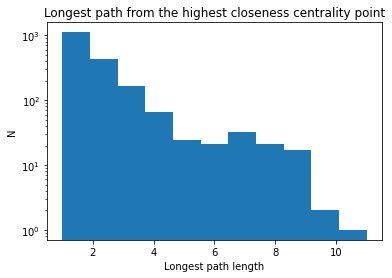

In [13]:
plt.figure(figsize=(6, 4))
plt.title("Longest path from the highest closeness centrality point")
plt.ylabel("N")
plt.yscale("log")
plt.xlabel("Longest path length")
plt.hist(centr, bins=11)
plt.show()

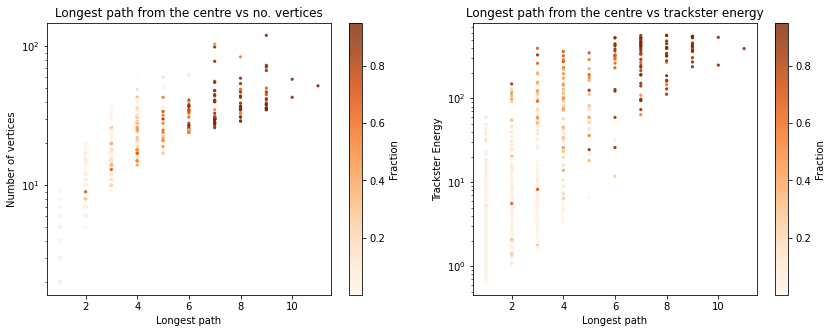

In [28]:
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title("Longest path from the centre vs no. vertices")
ax1.set_xlabel("Longest path")
ax1.set_ylabel("Number of vertices")
ax1.set_yscale("log")

sc1 = ax1.scatter(centr, nvertices, c=fracs, s=5, cmap="Oranges", alpha=0.8)
cbar1 = fig.colorbar(sc1, ax=ax1)
cbar1.set_label("Fraction")

ax2.set_title("Longest path from the centre vs trackster energy")
ax2.set_xlabel("Longest path")
ax2.set_ylabel("Trackster Energy")
ax2.set_yscale("log")

sc2 = ax2.scatter(centr, tenergy, c=fracs, s=5, cmap="Oranges", alpha=0.8)
cbar2 = fig.colorbar(sc2, ax=ax2)
cbar2.set_label("Fraction")

plt.show()